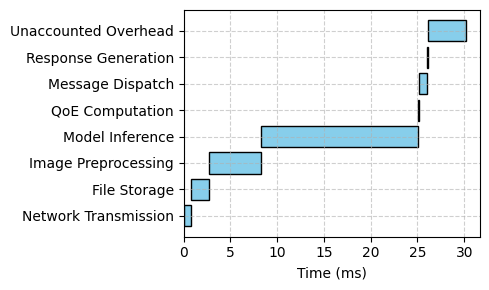

\begin{table}
\centering
\caption{Latency Breakdown with Duration and Percentage}
\begin{tabular}{|l|p{2cm}|p{2cm}|}
\hline
\textbf{Component} & \textbf{Latency (ms)} & \textbf{Percent (\%)} \\ \hline
Network Transmission & 0.787 & 2.61 \\ \hline
File Storage & 1.894 & 6.28 \\ \hline
Image Preprocessing & 5.623 & 18.64 \\ \hline
Model Inference & 16.796 & 55.67 \\ \hline
QoE Computation & 0.019 & 0.06 \\ \hline
Message Dispatch & 0.884 & 2.93 \\ \hline
Response Generation & 0.103 & 0.34 \\ \hline
Unaccounted Overhead & 4.066 & 13.48 \\ \hline
\end{tabular}
\end{table}


In [23]:
import pandas as pd
import matplotlib.pyplot as plt

def analyze_and_visualize_latencies(df):
    # Analyze request latencies
    df["Network Transmission"] = df["network_time"]
    df["File Storage"] = (df["image_save_time"] - df["server_receive_time"]) * 1000
    df["Image Preprocessing"] = (df["image_preprocessed_time"] - df["image_save_time"]) * 1000
    df["Model Inference"] = (df["image_predicted_time"] - df["image_preprocessed_time"]) * 1000
    df["QoE Computation"] = (df["qoe_computed_time"] - df["image_predicted_time"]) * 1000
    df["Message Dispatch"] = (df["event_produced_time"] - df["qoe_computed_time"]) * 1000
    df["Response Generation"] = (df["response_create_time"] - df["event_produced_time"]) * 1000

    # Calculate total processing time
    df["Total"] = (
        df["Network Transmission"] +
        df["File Storage"] +
        df["Image Preprocessing"] +
        df["Model Inference"] +
        df["QoE Computation"] +
        df["Message Dispatch"] +
        df["Response Generation"]
    )

    df["RTT"] = (df["client_receive_time"] - df["client_send_time"]) * 1000
    df["Unaccounted Overhead"] = df["RTT"] - df["Total"]
    df = df[["Network Transmission", "File Storage", "Image Preprocessing", "Model Inference", "QoE Computation", "Message Dispatch", "Response Generation", "Total", "RTT", "Unaccounted Overhead"]]
    # Calculate mean latencies for each component
    results_mean = df.mean().round(3).to_frame().T.drop(columns=["RTT", "Total"])

    # Prepare Gantt chart data
    task_durations = results_mean.iloc[0].to_dict()
    gantt_df = pd.DataFrame.from_dict(task_durations, orient='index', columns=["Duration"])
    gantt_df["Percentage (%)"] = (gantt_df["Duration"] / gantt_df["Duration"].sum()) * 100
    gantt_df["Percentage (%)"] = gantt_df["Percentage (%)"].round(2)

    gantt_df = gantt_df[gantt_df['Duration'] > 0]  # Filter out zero-duration tasks
    gantt_df["Start"] = gantt_df["Duration"].cumsum() - gantt_df["Duration"]
    gantt_df["End"] = gantt_df["Duration"].cumsum()

    # Plot Gantt Chart
    fig, ax = plt.subplots(figsize=(5, 3))
    for task, row in gantt_df.iterrows():
        ax.barh(task, row["Duration"], left=row["Start"], color="skyblue", edgecolor="black")

    ax.set_xlabel("Time (ms)")
    ax.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()

    # Generate LaTeX table with Duration and Percentage
    latex_code = ('\\begin{table}\n'
                  '\\centering\n'
                  '\\caption{Latency Breakdown with Duration and Percentage}\n'
                  '\\begin{tabular}{|l|p{2cm}|p{2cm}|}\n'
                  '\\hline\n'
                  '\\textbf{Component} & \\textbf{Latency (ms)} & \\textbf{Percent (\%)} \\\\ \\hline\n')

    # Iterate over each row of the DataFrame and add to LaTeX table
    for component, row in gantt_df.iterrows():
        latex_code += f'{component} & {row["Duration"]:.3f} & {row["Percentage (%)"]:.2f} \\\\ \\hline\n'

    # Close the LaTeX table
    latex_code += '\\end{tabular}\n\\end{table}'

    # Show plot and return LaTeX code
    plt.show()
    return latex_code


print(analyze_and_visualize_latencies(pd.read_csv("results.csv")))

In [24]:
df = pd.read_csv("results.csv")
df

,client_send_time,network_time,server_receive_time,image_save_time,image_preprocessed_time,image_predicted_time,qoe_computed_time,event_produced_time,response_create_time,client_receive_time
0,780278.306808,0.787,780264.352618,780264.355066,780264.363851,780264.384258,780264.384282,780264.386470,780264.386687,780278.350228
1,780278.350383,0.787,780264.392692,780264.394649,780264.400408,780264.417240,780264.417260,780264.418205,780264.418323,780278.381622
2,780278.381810,0.787,780264.423682,780264.425837,780264.431676,780264.448443,780264.448466,780264.449373,780264.449489,780278.412755
3,780278.414591,0.787,780264.456169,780264.458085,780264.463991,780264.480869,780264.480889,780264.481904,780264.482027,780278.445142
4,780278.445277,0.787,780264.486762,780264.488641,780264.496466,780264.513339,780264.513359,780264.514396,780264.514491,780278.477674
...,...,...,...,...,...,...,...,...,...,...
95,780281.197696,0.787,780267.239415,780267.241191,780267.246327,780267.263046,780267.263059,780267.263922,780267.263995,780281.227196
96,780281.227379,0.787,780267.268984,780267.270753,780267.276193,780267.292394,780267.292406,780267.293355,780267.293428,780281.256483
97,780281.256663,0.787,780267.298073,780267.299729,780267.305261,780267.321504,780267.321517,780267.322276,780267.322348,780281.285454
98,780281.285633,0.787,780267.327241,780267.328960,780267.334520,780267.350351,780267.350366,780267.351214,780267.351292,780281.314341


In [25]:
df["server_receive_time"] - df["client_send_time"]

0    -13.954190
1    -13.957691
2    -13.958129
3    -13.958422
4    -13.958515
        ...    
95   -13.958281
96   -13.958395
97   -13.958589
98   -13.958392
99   -13.958611
Length: 100, dtype: float64